# py4DSTEM quickstart
---

This notebook

- loads data,
- performs some initial visualizations, including virtual imaging and displaying diffraction data,
- detects and visualizes bragg disk positions,
- and saves outputs.

### Data
The 4DSTEM data was collected by Steven Zeltmann.

To download the data, please [go here](https://drive.google.com/file/d/1B-xX3F65JcWzAg0v7f1aVwnawPIfb5_o/view?usp=sharing).  Place the file somewhere on your filesystem, then in the cell immediately after this one, update the variable `filepath_input` to reflect that path to the file.  Then update `filepath_output` to set wherever you want to save the outputs.


### Version info

Last updated on 2022-06-07 with py4DSTEM version 0.12.22.

In [1]:
# Make sure to point these filepaths at the location the data was downloaded (or place the data in the same folder as the notebook)
filepath_input = "small4DSTEMscan_10x10.dm3"
filepath_output = "quickstart_output.h5"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM

In [3]:
py4DSTEM.__version__

'0.12.22'

## Load the data

In [4]:
# Load a .dm3 file
datacube = py4DSTEM.io.read(filepath_input)

In [5]:
# This file's metadata didn't contain the shape of the beam raster, so the data is reshaped to set that here
datacube.set_scan_shape(10,10)

In [6]:
# The data is shaped like
#     (x_R,y_R,x_Q,y_Q)
# where R/Q are real/diffraction space
datacube.data.shape

(10, 10, 512, 512)

In [7]:
# Cropping and binning
# Note that for large datasets, binning can also be performed during loading, for some fileformats.
# See the docstring for io.read
datacube.crop_data_real(2,10,2,10)
datacube.bin_data_diffraction(2)

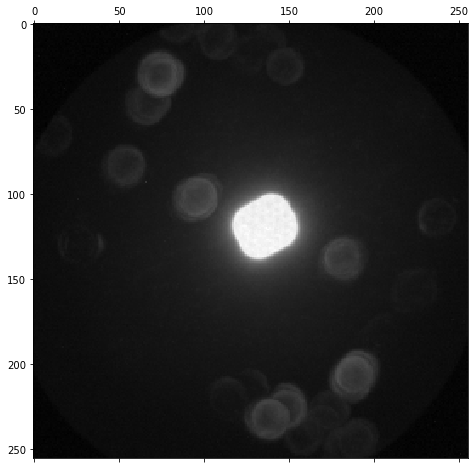

In [8]:
# Maximum diffraction pattern
# This is a computationally fast and visually information rich way to slice into a 4D-STEM dataset.
# Bragg scattering immediately pops out.  Here we can also clearly see the presence of diffraction shifts
# in the shape of the bright central region.
max_dp = np.max(datacube.data, axis=(0,1))
py4DSTEM.visualize.show(max_dp, scaling='power', power=0.5)

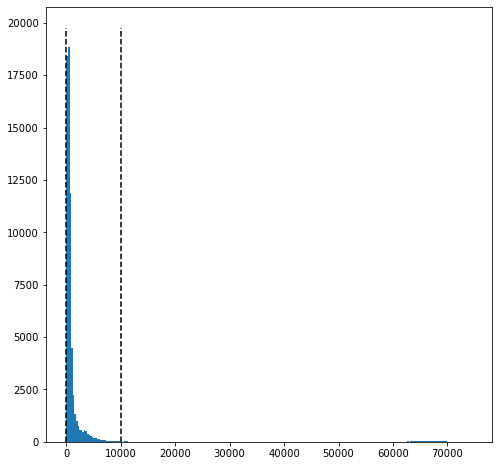

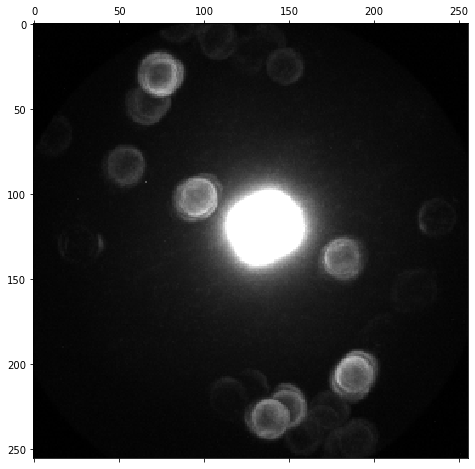

In [9]:
# Show an image histogram, pick new clipvalues, and display the image
min,max = 0,10000
py4DSTEM.visualize.show(max_dp,hist=True,clipvals='manual',min=min,max=max)
py4DSTEM.visualize.show(max_dp,clipvals='manual',min=min,max=max)

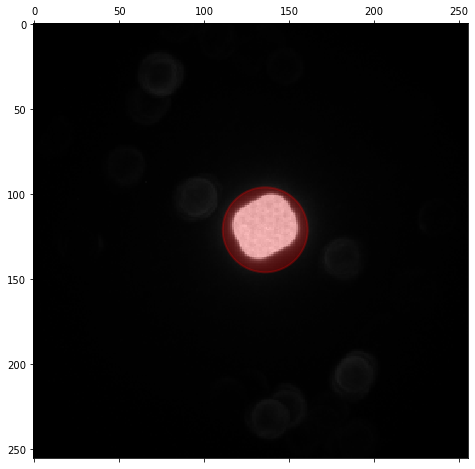

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 27514.91it/s]


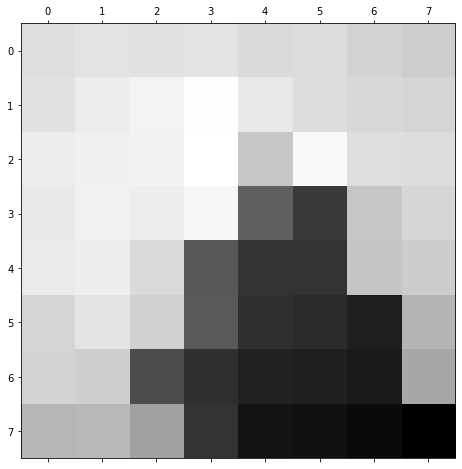

In [10]:
# Get a bright-field image

# Position a bright-field detector
x0,y0 = 121,136
R = 25
py4DSTEM.visualize.show_circles(max_dp,center=(x0,y0),R=R,alpha=0.25)

# Get the image
BF_image = py4DSTEM.process.virtualimage.get_virtualimage(datacube,((x0,y0),R))

# Show
py4DSTEM.visualize.show(BF_image)

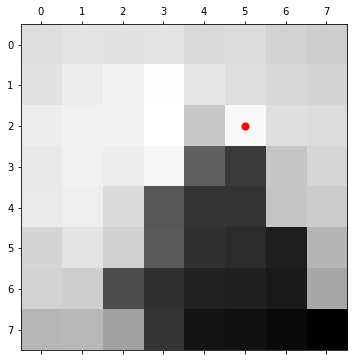

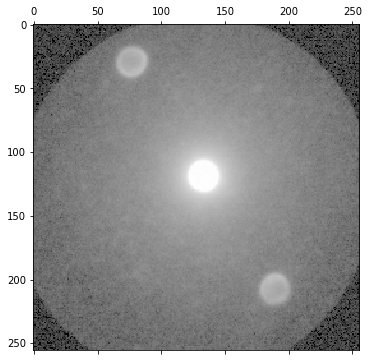

In [11]:
# Visualize a single diffraction pattern
rx,ry = 2,5

py4DSTEM.visualize.show_points(BF_image,rx,ry,figsize=(6,6))
py4DSTEM.visualize.show(datacube.data[rx,ry,:,:],figsize=(6,6),scaling='log')

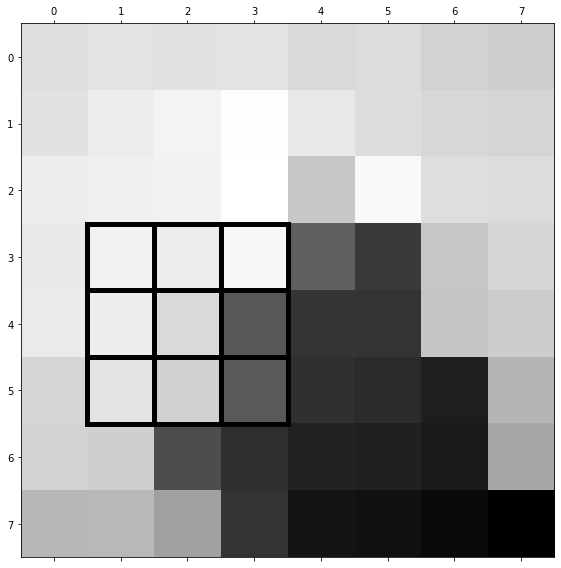

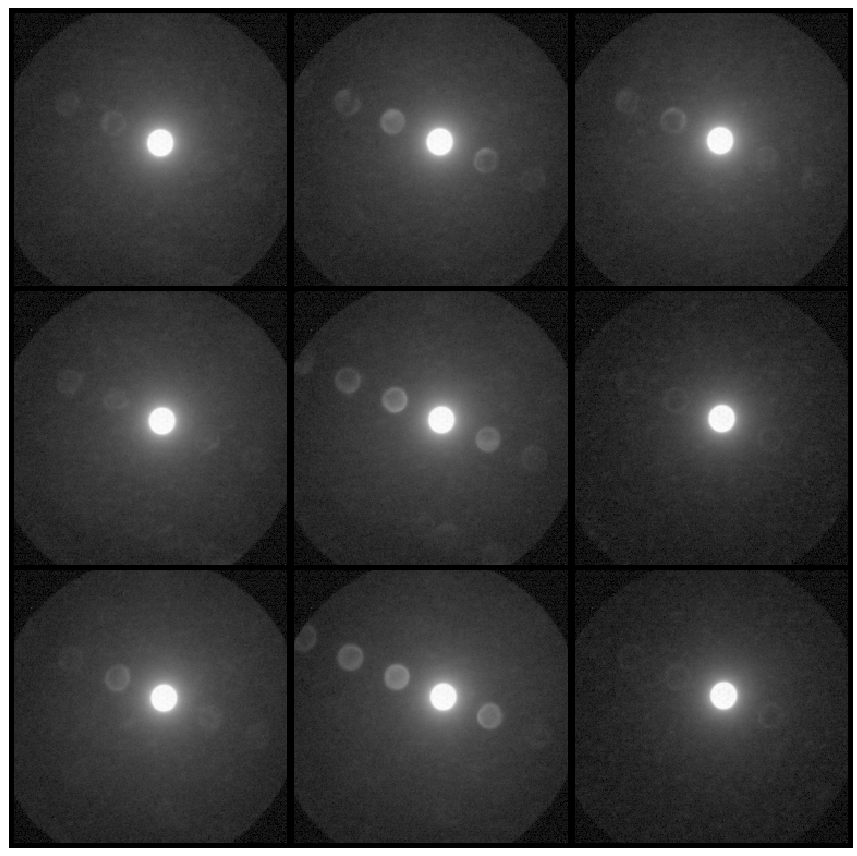

In [12]:
# Visualize a grid of diffraction patterns
x0,y0 = 3,1
xL,yL = 3,3

py4DSTEM.visualize.show_grid_overlay(BF_image,x0,y0,xL,yL,color='k',linewidth=5,figsize=(8,8))
py4DSTEM.visualize.show_DP_grid(datacube,x0,y0,xL,yL,bordercolor='k',borderwidth=5,axsize=(4,4),
                                scaling='power',power=0.25)

### Bragg disk detection

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 72.95it/s]


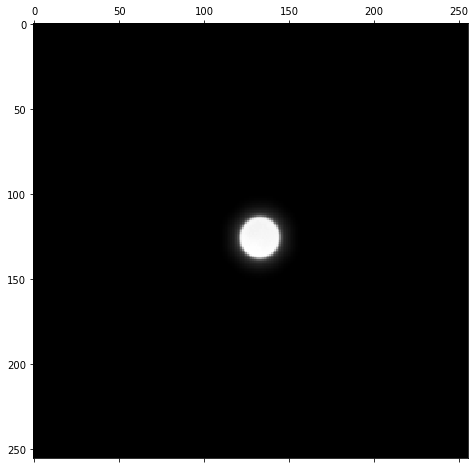

In [13]:
# Construct an image of the vacuum probe, to use as a template for finding the other Bragg disks
# This step can look very different for different datasets
# The best practice is to always record a vacuum probe of every camera length / convergence angle combo
# you use in a day of experiments!
probe = py4DSTEM.process.diskdetection.get_probe_from_vacuum_4Dscan(datacube)
py4DSTEM.visualize.show(probe)

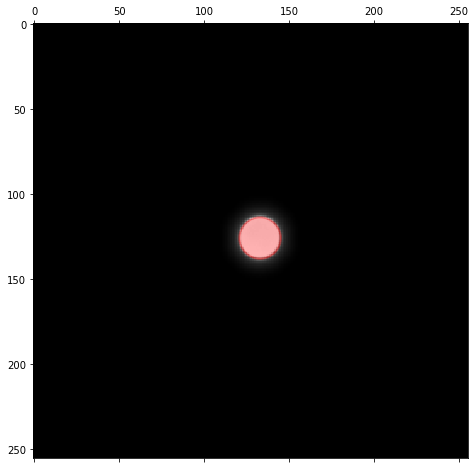

In [14]:
# Get the probe radius
r,qx0,qy0 = py4DSTEM.process.calibration.get_probe_size(probe)
py4DSTEM.visualize.show_circles(probe,(qx0,qy0),r)

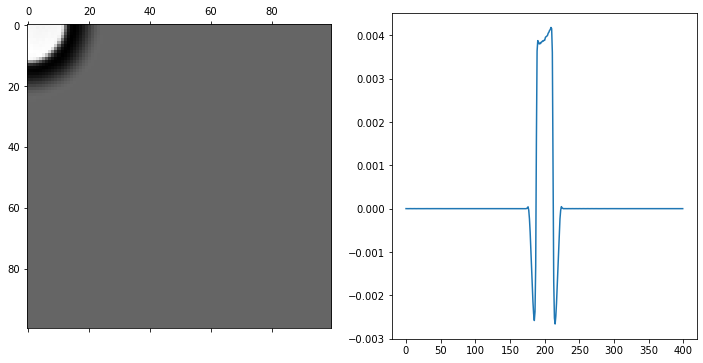

In [15]:
# Preprocessing for the template matching step
r_trench = r*2
probe_kernel = py4DSTEM.process.diskdetection.get_probe_kernel_edge_sigmoid(probe,r,r_trench,(qx0,qy0))
py4DSTEM.visualize.show_kernel(probe_kernel,R=100,L=200,W=5)

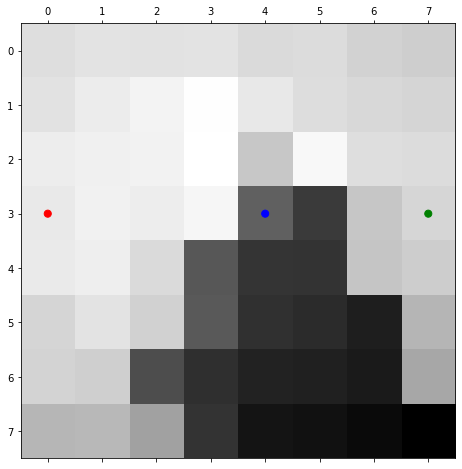

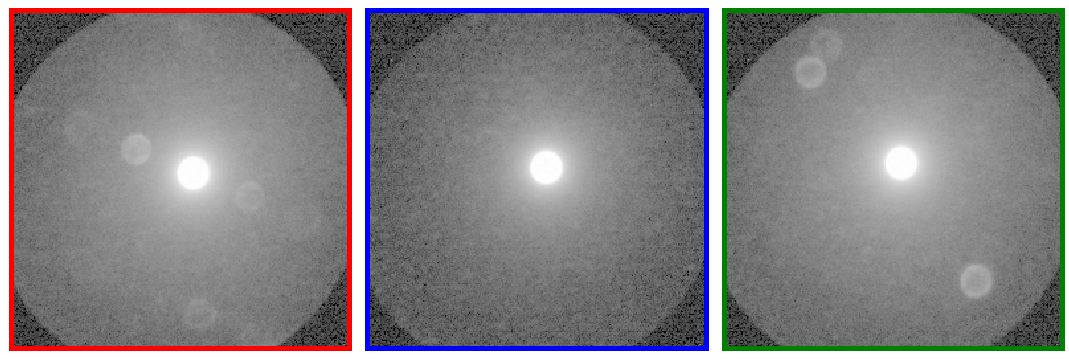

In [16]:
# Select a few diffraction patterns to test disk detection parameters on

# In most cases, running disk detection on the full dataset will be slow, and it can be helpful to 
# manually tune some the parameters for this algorithm. Here we're picking a few DP to tune on.

rxs = 3,3,3
rys = 0,4,7
colors=['r','b','g']

dp1 = datacube.data[rxs[0],rys[0],:,:]
dp2 = datacube.data[rxs[1],rys[1],:,:]
dp3 = datacube.data[rxs[2],rys[2],:,:]

py4DSTEM.visualize.show_points(BF_image,x=rxs,y=rys,pointcolor=colors)
py4DSTEM.visualize.show_image_grid(lambda i:[dp1,dp2,dp3][i],H=1,W=3,axsize=(5,5),
                                   scaling='log',get_bordercolor=lambda i:colors[i])

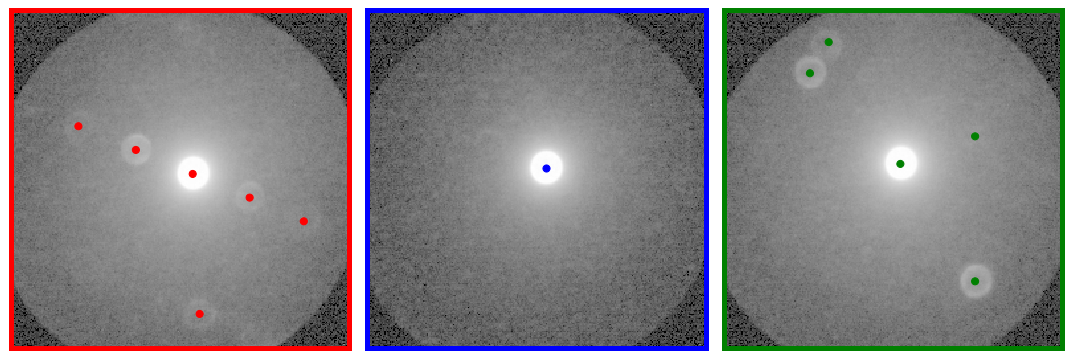

In [17]:
# Run the disk detection on the selected DPs

corrPower=1.0
sigma=1
edgeBoundary=20
minRelativeIntensity=0.
minAbsoluteIntensity=20
relativeToPeak=0
minPeakSpacing=20
maxNumPeaks=70
subpixel='multicorr'
upsample_factor=16

disks_selected = py4DSTEM.process.diskdetection.find_Bragg_disks_selected(
    datacube,
    probe_kernel,
    rxs,
    rys,
    corrPower=corrPower,
    sigma=sigma,
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minAbsoluteIntensity=minAbsoluteIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

py4DSTEM.visualize.show_image_grid(lambda i:[dp1,dp2,dp3][i],H=1,W=3,axsize=(5,5),
                                   scaling='log',
                                   get_bordercolor=lambda i:colors[i],
                                   get_x=lambda i:disks_selected[i].data['qx'],
                                   get_y=lambda i:disks_selected[i].data['qy'],
                                   #get_s=lambda i:disks_selected[i].data['intensity'],  
                                   get_pointcolors=lambda i:colors[i])

In [18]:
# Run disk detection on the entire dataset
disks = py4DSTEM.process.diskdetection.find_Bragg_disks(
    datacube,
    probe_kernel,
    corrPower=corrPower,
    sigma=sigma,
    edgeBoundary=edgeBoundary,
    minRelativeIntensity=minRelativeIntensity,
    minAbsoluteIntensity=minAbsoluteIntensity,
    relativeToPeak=relativeToPeak,
    minPeakSpacing=minPeakSpacing,
    maxNumPeaks=maxNumPeaks,
    subpixel=subpixel,
    upsample_factor=upsample_factor)

Finding Bragg Disks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 64.0/64.0 [00:00<00:00, 73.6DP/s]


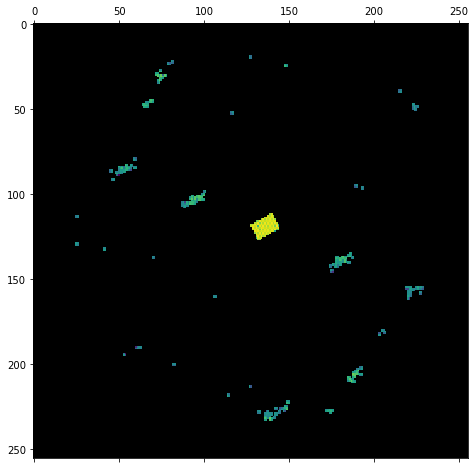

In [19]:
# Compute and show the Bragg vector map.
braggvectormap = py4DSTEM.process.diskdetection.get_bragg_vector_map_raw(disks,datacube.Q_Nx,datacube.Q_Ny)
py4DSTEM.visualize.show(braggvectormap,cmap='viridis',scaling='log')

### Save and load

In [20]:
# py4DSTEM saves data as DataObjects - there's seven of them, and they are:
# DataCubes, CountedDataCubes, DiffractionSlices, RealSlices, PointList, PointListArray, Coordinates
max_dp_DiffSlice = py4DSTEM.io.DiffractionSlice(data=max_dp, name='max_dp')
BF_image_RealSlice = py4DSTEM.io.RealSlice(data=BF_image, name='BF_image')
three_dps = py4DSTEM.io.DiffractionSlice(data=np.dstack([dp1,dp2,dp3]),
                                                         slicelabels=['dp1','dp2','dp3'],
                                                         name='three_dps')
dp3_disks = disks_selected[2]
dp3_disks.name = 'some_bragg_disks'
disks.name = 'braggpeaks'
datacube.name = '4ddatacube'

data = [max_dp_DiffSlice,BF_image_RealSlice,three_dps,dp3_disks,disks,datacube]
py4DSTEM.io.save(filepath_output,data,overwrite=True)

Saving DiffractionSlice 'max_dp'...
Saving RealSlice 'BF_image'...
Saving DiffractionSlice 'three_dps'...
Saving PointList 'some_bragg_disks'...
Saving PointListArray 'braggpeaks'...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 2811.49it/s]

Saving DataCube '4ddatacube'...


In [21]:
# Show the file contents
py4DSTEM.io.read(filepath_output)

py4DSTEM file version 0.12.22
Index     Type              Shape                   Name                                                  
-----     ----              -----                   ----                                                  
  0       DataCube          (8, 8, 256, 256)        4ddatacube                                            
  1       DiffractionSlice  (256, 256)              max_dp                                                
  2       DiffractionSlice  (256, 256, 3)           three_dps                                             
  3       RealSlice         (8, 8)                  BF_image                                              
  4       PointList         (3, 5)                  some_bragg_disks                                      
  5       PointListArray    (8, 8, 3, -1)           braggpeaks                                            


In [22]:
# Load the data
max_dp_h5 = py4DSTEM.io.read(filepath_output,data_id='max_dp')
max_dp_h5 = max_dp_h5.data

datacube_h5 = py4DSTEM.io.read(filepath_output,data_id='4ddatacube')

# Check that it's the same
assert(not np.any(max_dp_h5-max_dp))
assert(not np.any(datacube_h5.data-datacube.data))